#0) Imports and Installs

In [1]:
!pip install yfinance

In [2]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt


# 1) [Code Snippet 1] IPOs data from Web

* learn dataframes "stacking" (UNION ALL)
* learn about type casting
* generate new columns (simple and with function)


In [3]:
import pandas as pd
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/2023/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

C:\Users\rcata\AppData\Local\Temp\ipykernel_21008\4213396001.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  ipo_dfs = pd.read_html(response.text)


In [4]:
ipos_2023 = ipo_dfs[0]
ipos_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      154 non-null    object
 1   Symbol        154 non-null    object
 2   Company Name  154 non-null    object
 3   IPO Price     154 non-null    object
 4   Current       154 non-null    object
 5   Return        154 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [5]:
url = "https://stockanalysis.com/ipos/2024/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

C:\Users\rcata\AppData\Local\Temp\ipykernel_21008\1522156903.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  ipo_dfs = pd.read_html(response.text)


In [6]:
ipos_2024 = ipo_dfs[0]
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      64 non-null     object
 1   Symbol        64 non-null     object
 2   Company Name  64 non-null     object
 3   IPO Price     64 non-null     object
 4   Current       64 non-null     object
 5   Return        64 non-null     object
dtypes: object(6)
memory usage: 3.1+ KB


In [7]:
# "stacking dataframes"
# pd.concat() is used to concatenate the DataFrames vertically.
# The ignore_index=True parameter ensures that the resulting DataFrame has a new index,
# ignoring the original indices of the input DataFrames.
# The stacked_df now contains the concatenated DataFrame.
stacked_ipos_df = pd.concat([ipos_2024, ipos_2023], ignore_index=True)

In [8]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"May 1, 2024",VIK,Viking Holdings Ltd.,$24.00,$28.94,20.58%


In [9]:
# Need to convert everything to a proper type (date, str, int, float, etc.)
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      218 non-null    object
 1   Symbol        218 non-null    object
 2   Company Name  218 non-null    object
 3   IPO Price     218 non-null    object
 4   Current       218 non-null    object
 5   Return        218 non-null    object
dtypes: object(6)
memory usage: 10.3+ KB


In [12]:
stacked_ipos_df['IPO Date'][0] = pd.to_datetime(stacked_ipos_df['IPO Date'][0])

In [13]:
# convert to datetime
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'])

In [14]:
# Problem --> not always the columns are filled
missing_prices_df = stacked_ipos_df[stacked_ipos_df['IPO Price'].astype(str).str.find('-') >= 0]
missing_prices_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return


In [15]:
# it has some missing values --> use defensive errors='coerce' (if don't have time to crack into the data errors)
#     : pd.to_numeric() function call, which will convert problematic values to NaN.
#     otherwise you'll get a ValueError: Unable to parse string "-" at position 9
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'])

In [16]:
# Convert "Current" column
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100

In [17]:
# Correctly applied transformations with 'defensive' techniques, but now not all are non-null
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      218 non-null    datetime64[ns]
 1   Symbol        218 non-null    object        
 2   Company Name  218 non-null    object        
 3   IPO Price     218 non-null    float64       
 4   Current       218 non-null    float64       
 5   Return        218 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.3+ KB


In [18]:
# simple way of checking NULLs
# (you need to understand how vector operations work .isnull() and calls chaining .isnull().sum())
stacked_ipos_df.isnull().sum()

IPO Date        0
Symbol          0
Company Name    0
IPO Price       0
Current         0
Return          0
dtype: int64

In [19]:
# Do you want to leave the record or not?
stacked_ipos_df[stacked_ipos_df.Return.isnull()]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return


In [20]:
# now you can operate with columns as a numeric type
stacked_ipos_df['IPO Price'].mean()

11.060229357798166

In [21]:
# generate a new field -- SIMPLE calculation (no function needed)
stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']

In [22]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase
0,2024-05-01,VIK,Viking Holdings Ltd.,24.0,28.94,0.2058,4.94


In [23]:
# Descriptive Analytics of a dataset
stacked_ipos_df.describe()

,IPO Date,IPO Price,Current,Return,Price Increase
count,218,218.000000,218.000000,218.000000,218.000000
mean,2023-09-08 03:44:35.229357824,11.060229,11.192936,-0.206903,0.132706
min,2023-01-13 00:00:00,2.500000,0.000000,-0.999600,-21.260000
25%,2023-04-20 00:00:00,4.000000,1.277500,-0.733025,-3.670000
50%,2023-09-14 12:00:00,8.000000,5.505000,-0.215000,-1.645000
75%,2024-01-24 18:00:00,13.750000,10.827500,0.060750,0.567500
max,2024-05-01 00:00:00,92.000000,120.330000,2.500000,55.980000
std,NaN,11.245650,17.501652,0.646938,9.394979


In [24]:
# some visualisation: bar chart using Plotly Express
import plotly.express as px

# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()

In [25]:
# To be used for home assignment: 'You can notice a bump in the price after the IPO? And after that the price goes down
# You're asked to design a simple strategy to buy and hold for X days (at 'Adj.Close' price, no fees)
# Find an optimal X between 1 and 30, that delivers you a MAX mean return on ALL 2023 IPOs?
# Write down the answer X (a number between 1 and 30)

# What is the distribution of other returns 25-50-75% quantiles? Compare mean and median returns for 2023 (median may be more robust),
  # are you losing money in 25% cases (if 25% quantile returns is < 0)
  # Try the same X for all deals in 2024.  How the mean return in 2024 (out of sample data) is different from 2023 data?

# REDDIT - recent IPO
# https://finance.yahoo.com/quote/RDDT/
reddit = yf.download(tickers = "RDDT",
                     period = "max",
                     interval = "1d")

reddit.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-30,45.470001,46.755001,44.150002,44.439999,44.439999,1752900
2024-05-01,44.869999,47.700001,44.599998,45.880001,45.880001,1598100
2024-05-02,46.610001,49.639000,45.720001,47.700001,47.700001,2365000
2024-05-03,48.439999,48.700001,46.240002,46.639999,46.639999,1188300
2024-05-06,46.990002,49.869999,46.750000,48.270000,48.270000,2112200


<Axes: title={'center': "Reddit's (RDDT) price after the IPO"}, xlabel='Date'>

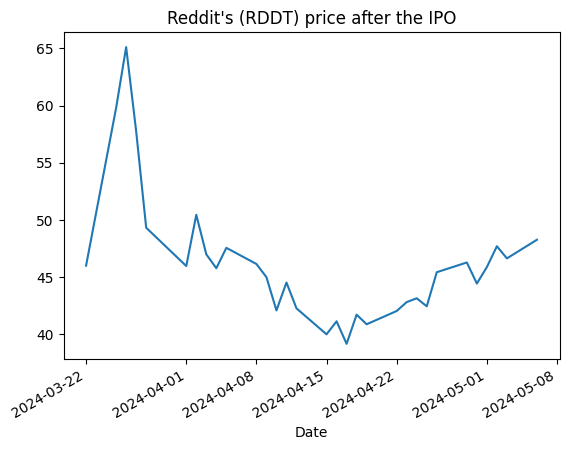

In [26]:
reddit['Adj Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO')

#2) OHLCV data transformations

## 2.1 [Code Snippet 2] Time series for OHLCV

In [27]:
nvo_df = yf.download(tickers = "NVO",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [28]:
# big plus of an API's data: good typing from the box!
# notice DatetimeIndex - it is a recognised date
nvo_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10845 entries, 1981-04-30 to 2024-05-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10845 non-null  float64
 1   High       10845 non-null  float64
 2   Low        10845 non-null  float64
 3   Close      10845 non-null  float64
 4   Adj Close  10845 non-null  float64
 5   Volume     10845 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 593.1 KB


In [29]:
nvo_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-30,128.050003,130.460007,127.489998,128.309998,128.309998,7841000
2024-05-01,127.800003,130.130005,127.500000,129.210007,129.210007,5184400
2024-05-02,127.940002,127.940002,123.830002,124.019997,124.019997,8487100
2024-05-03,122.919998,123.769997,121.290001,123.050003,123.050003,5932900
2024-05-06,122.000000,124.639999,121.779999,124.589996,124.589996,3634800


In [30]:
# filter on date (index)
nvo_df_filtered_from_2020 = nvo_df[nvo_df.index>='2020-01-01']
nvo_df_filtered_from_2024 = nvo_df[nvo_df.index>='2024-01-01']

<Axes: title={'center': 'Novo Nordisk A/S (NVO) price daily'}, xlabel='Date'>

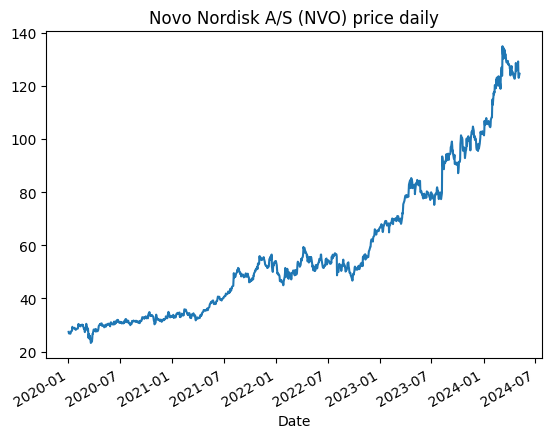

In [31]:
# Chaining: select one column, draw a plot, of a type line
nvo_df_filtered_from_2020['Adj Close'].plot.line(title='Novo Nordisk A/S (NVO) price daily')

In [32]:
# generating new fields (using DateTime features):

nvo_df['Ticker'] = 'NVO'
nvo_df['Year']= nvo_df.index.year
nvo_df['Month'] = nvo_df.index.month
nvo_df['Weekday'] = nvo_df.index.weekday
nvo_df['Date'] = nvo_df.index.date # to be used in joins

In [33]:
nvo_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,Date
Date,,,,,,,,,,,
2024-04-30,128.050003,130.460007,127.489998,128.309998,128.309998,7841000,NVO,2024,4,1,2024-04-30
2024-05-01,127.800003,130.130005,127.500000,129.210007,129.210007,5184400,NVO,2024,5,2,2024-05-01
2024-05-02,127.940002,127.940002,123.830002,124.019997,124.019997,8487100,NVO,2024,5,3,2024-05-02
2024-05-03,122.919998,123.769997,121.290001,123.050003,123.050003,5932900,NVO,2024,5,4,2024-05-03
2024-05-06,122.000000,124.639999,121.779999,124.589996,124.589996,3634800,NVO,2024,5,0,2024-05-06


In [34]:
# shift ALL values (on x periods forward (+1) and backward (-1))
# equivalent of joining with a dataframe of the same vector, but with shifted date index
nvo_df['adj_close_minus_1'] = nvo_df['Adj Close'].shift(-1)
nvo_df['adj_close_plus_1'] = nvo_df['Adj Close'].shift(1)

nvo_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,Date,adj_close_minus_1,adj_close_plus_1
Date,,,,,,,,,,,,,
2024-04-30,128.050003,130.460007,127.489998,128.309998,128.309998,7841000,NVO,2024,4,1,2024-04-30,129.210007,126.879997
2024-05-01,127.800003,130.130005,127.500000,129.210007,129.210007,5184400,NVO,2024,5,2,2024-05-01,124.019997,128.309998
2024-05-02,127.940002,127.940002,123.830002,124.019997,124.019997,8487100,NVO,2024,5,3,2024-05-02,123.050003,129.210007
2024-05-03,122.919998,123.769997,121.290001,123.050003,123.050003,5932900,NVO,2024,5,4,2024-05-03,124.589996,124.019997
2024-05-06,122.000000,124.639999,121.779999,124.589996,124.589996,3634800,NVO,2024,5,0,2024-05-06,NaN,123.050003


In [35]:
# historical growth
nvo_df['growth_1d'] = nvo_df['Adj Close'] / nvo_df['Adj Close'].shift(1)           # nvo_df['adj_close_plus_1']
nvo_df['growth_30d'] = nvo_df['Adj Close'] / nvo_df['Adj Close'].shift(30)

# FUTURE Growth : for regression models
nvo_df['growth_future_1d'] = nvo_df['Adj Close'].shift(-1) / nvo_df['Adj Close']   # nvo_df['adj_close_minus_1']

# FUTURE Growth: for binary models
nvo_df['is_positive_growth_1d_future'] = np.where(nvo_df['growth_future_1d'] > 1, 1, 0)

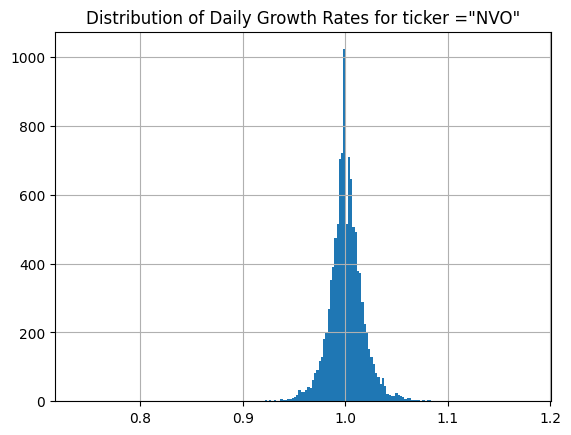

In [36]:
# normally the growth in 1 day is +-10%, while a lot of it is around 0% (around 1.)
plt.title('Distribution of Daily Growth Rates for ticker ="NVO"')
nvo_df.growth_1d.hist(bins=200)
plt.show()

<Axes: title={'center': 'Distribution of 2-days Growth Rates for ticker = "NVO"'}>

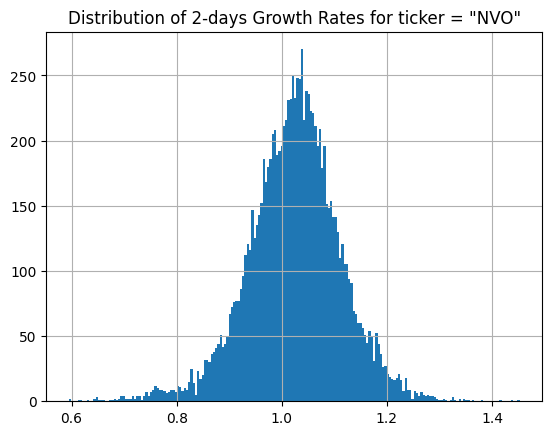

In [37]:
# you can see that the growth is can be much wider in 30 days (+- 30%)
plt.title('Distribution of 2-days Growth Rates for ticker = "NVO"')

nvo_df.growth_30d.hist(bins=200)

In [38]:
# for modeling: we use growth_1d, growth_2d as feature
COLUMNS = [k for k in nvo_df.keys() if k.find('growth')>=0 or k=='Adj Close']
nvo_df[COLUMNS].tail()

,Adj Close,growth_1d,growth_30d,growth_future_1d,is_positive_growth_1d_future
Date,,,,,
2024-04-30,128.309998,1.011270,0.972502,1.007014,1
2024-05-01,129.210007,1.007014,0.990654,0.959833,0
2024-05-02,124.019997,0.959833,0.958229,0.992179,0
2024-05-03,123.050003,0.992179,0.954616,1.012515,1
2024-05-06,124.589996,1.012515,0.967614,NaN,0


In [39]:
# Calculate the distribution if future growth
nvo_df.is_positive_growth_1d_future.value_counts() / len(nvo_df)

is_positive_growth_1d_future
0    0.512863
1    0.487137
Name: count, dtype: float64

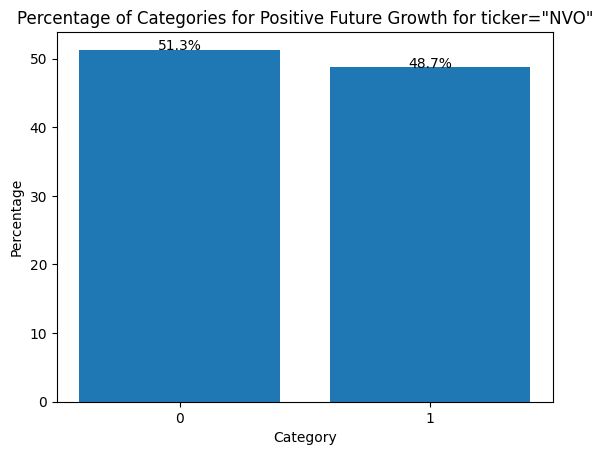

In [40]:
# Calculate value counts
value_counts = nvo_df['is_positive_growth_1d_future'].value_counts()

# Calculate percentage of each category
percentage = (value_counts / len(nvo_df)) * 100

# Plot as a bar chart
plt.bar(percentage.index.astype(str), percentage)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Percentage of Categories for Positive Future Growth for ticker="NVO"')

# Add percentage values on top of each bar
for i, value in enumerate(percentage):
    plt.text(i, value + 0, f'{value:.1f}%', ha='center')

plt.show()

## 2.2) [Code Snippet 6] Candlestick chart for OHLCV

In [41]:
# Candlestick charts : https://plotly.com/python/candlestick-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=nvo_df_filtered_from_2020.index,
                open=nvo_df_filtered_from_2020.Open,
                high=nvo_df_filtered_from_2020.High,
                low=nvo_df_filtered_from_2020.Low,
                close=nvo_df_filtered_from_2020.Close)
               ])

fig.update_layout(
    title="NVO's daily candlestick chart from 2020",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()

# 3) Macro Indicators

## 3.0) Previous indicators from module 1

In [42]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2024; month= 5; day=6
Period for indexes: 1954-05-06 to 2024-05-06 


In [43]:
# reuse code for ealier covered indicators
dax_daily = yf.download(tickers = "^GDAXI",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [44]:
for i in [1,3,7,30,90,365]:
  #DEBUG: dax_daily['Adj Close_sh_m_'+str(i)+'d'] = dax_daily['Adj Close'].shift(i)
  dax_daily['growth_dax_'+str(i)+'d'] = dax_daily['Adj Close'] / dax_daily['Adj Close'].shift(i)

In [45]:
dax_daily.head()

,Open,High,Low,Close,Adj Close,Volume,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,
1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,1005.190002,0,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-04,956.489990,956.489990,956.489990,956.489990,956.489990,0,0.951551,NaN,NaN,NaN,NaN,NaN
1988-01-05,996.099976,996.099976,996.099976,996.099976,996.099976,0,1.041412,NaN,NaN,NaN,NaN,NaN
1988-01-06,1006.010010,1006.010010,1006.010010,1006.010010,1006.010010,0,1.009949,1.000816,NaN,NaN,NaN,NaN
1988-01-07,1014.469971,1014.469971,1014.469971,1014.469971,1014.469971,0,1.008409,1.060617,NaN,NaN,NaN,NaN


In [46]:
dax_daily.tail(2)

,Open,High,Low,Close,Adj Close,Volume,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,
2024-05-03,17900.150391,18105.820312,17900.019531,18001.599609,18001.599609,71259900,1.005873,0.993558,0.992499,1.000784,1.078753,1.237957
2024-05-06,18001.130859,18199.150391,18001.130859,18175.210938,18175.210938,46036600,1.009644,1.013553,1.004783,1.008886,1.087933,1.263628


In [47]:
GROWTH_KEYS = [k for k in dax_daily.keys() if k.startswith('growth')]
dax_daily_to_merge = dax_daily[GROWTH_KEYS]
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2024-05-06,1.009644,1.013553,1.004783,1.008886,1.087933,1.263628


In [48]:
def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in [1,3,7,30,90,365]:
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Adj Close'] / df['Adj Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]

In [49]:
# https://finance.yahoo.com/quote/%5EGSPC/
# SNP - SNP Real Time Price. Currency in USD
snp500_daily = yf.download(tickers = "^GSPC",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [50]:
snp500_to_merge = get_growth_df(snp500_daily,'snp500')
snp500_to_merge.tail(2)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2024-05-03,1.012557,1.018289,1.011073,0.97830,1.078484,1.299306
2024-05-06,1.010326,1.032351,1.026210,0.98979,1.085029,1.306506


In [51]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch
dji_daily = yf.download(tickers = "^DJI",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [52]:
dji_daily_to_merge = get_growth_df(dji_daily,'dji')
dji_daily_to_merge.tail(2)

,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
Date,,,,,,
2024-05-03,1.011773,1.022735,1.005584,0.972206,1.034497,1.152904
2024-05-06,1.004566,1.025037,1.020125,0.984202,1.034810,1.151325


In [53]:
# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI
epi_etf_daily = yf.download(tickers = "EPI",
                     period = "max",
                     interval = "1d")
epi_etf_daily.tail(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-03,45.480000,45.560001,45.410000,45.560001,45.560001,1121100
2024-05-06,45.099998,45.110001,44.919998,45.020000,45.020000,1533600


In [54]:
epi_etf_daily_to_merge = get_growth_df(epi_etf_daily,'epi')
epi_etf_daily_to_merge.tail(2)

,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d
Date,,,,,,
2024-05-03,0.996937,1.008857,1.019239,1.066230,1.122997,1.390207
2024-05-06,0.988147,0.995137,0.999112,1.055321,1.105871,1.374986


In [55]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=start)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1
gdppot.tail(2)

,GDPPOT,gdppot_us_yoy,gdppot_us_qoq
DATE,,,
2024-01-01,22618.15,0.022251,0.005466
2024-04-01,22739.00,0.022151,0.005343


In [56]:
gdppot_to_merge = gdppot[['gdppot_us_yoy','gdppot_us_qoq']]
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2024-04-01,0.022151,0.005343


In [57]:
# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
# The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy"
# is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy.
# This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=start)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl.tail(2)

,CPILFESL,cpi_core_yoy,cpi_core_mom
DATE,,,
2024-02-01,315.565,0.037620,0.003584
2024-03-01,316.698,0.037973,0.003590


In [58]:
cpilfesl_to_merge = cpilfesl[['cpi_core_yoy','cpi_core_mom']]
cpilfesl_to_merge.tail(2)

,cpi_core_yoy,cpi_core_mom
DATE,,
2024-02-01,0.037620,0.003584
2024-03-01,0.037973,0.003590


In [59]:
# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=start)
fedfunds.tail(2)

,FEDFUNDS
DATE,
2024-03-01,5.33
2024-04-01,5.33


In [60]:
# https://fred.stlouisfed.org/series/DGS1
dgs1 = pdr.DataReader("DGS1", "fred", start=start)
dgs1.tail(2)

,DGS1
DATE,
2024-05-02,5.16
2024-05-03,5.12


In [61]:
# https://fred.stlouisfed.org/series/DGS5
dgs5 = pdr.DataReader("DGS5", "fred", start=start)
dgs5.tail(2)

,DGS5
DATE,
2024-05-02,4.57
2024-05-03,4.48


In [62]:
# https://fred.stlouisfed.org/series/DGS10
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
dgs10.tail(2)

,DGS10
DATE,
2024-05-02,4.58
2024-05-03,4.50


## 3.1) [Code snippet 3] VIX - Volatility Index

In [63]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/
vix = yf.download(tickers = "^VIX",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [64]:
vix.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-03,14.51,14.58,13.48,13.49,13.49,0
2024-05-06,13.98,14.02,13.44,13.49,13.49,0


In [65]:
vix_to_merge = vix['Adj Close']
vix_to_merge.tail()

Date
2024-04-30    15.65
2024-05-01    15.39
2024-05-02    14.68
2024-05-03    13.49
2024-05-06    13.49
Name: Adj Close, dtype: float64

<Axes: title={'center': 'VIX value over time'}, xlabel='Date'>

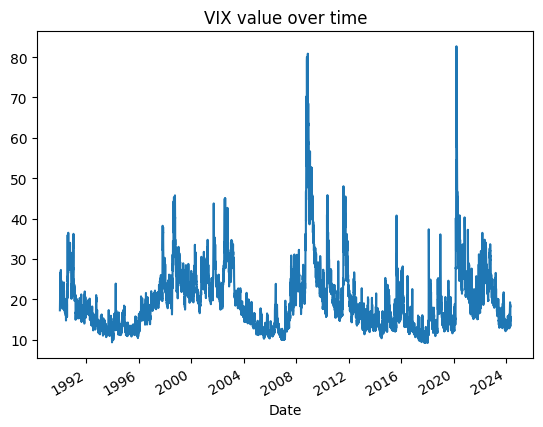

In [66]:
# Static graphs: hard to zoom in and get the exact dates of spikes
vix['Adj Close'].plot.line(title = "VIX value over time")

In [67]:
# Dynamic visualisation of VIX prices
fig = px.line(vix,
              x=vix.index,
              y="Adj Close",
              title='VIX over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.2) Gold - other assets

In [68]:
# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF
gold = yf.download(tickers = "GC=F",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [69]:
gold.tail(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-06,2334.800049,2338.699951,2328.199951,2332.100098,2332.100098,15059


In [70]:
gold_to_merge = get_growth_df(gold,'gold')
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2024-05-03,0.999913,1.003317,0.989030,1.053427,1.117593,1.312289
2024-05-06,1.014398,1.014001,1.000987,1.080626,1.133078,1.342293


In [71]:
# Dynamic visualisation of GOLD prices
fig = px.line(gold,
              x=gold.index,
              y="Adj Close",
              title='GOLD over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.3) WTI Crude and Brent Oil

In [72]:
# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/
crude_oil = yf.download(tickers = "CL=F",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [73]:
crude_oil.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-03,79.070000,79.629997,77.959999,78.110001,78.110001,324438
2024-05-06,78.720001,79.019997,78.550003,78.650002,78.650002,9954


In [74]:
crude_oil_to_merge = get_growth_df(crude_oil,'wti_oil')
crude_oil_to_merge.tail(2)

,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
Date,,,,,,
2024-05-03,0.989360,0.953375,0.943244,0.963488,1.061854,0.975400
2024-05-06,1.006913,0.995570,0.941127,0.975443,1.040757,0.986454


In [75]:
# Dynamic visualisation
fig = px.line(crude_oil,
              x=crude_oil.index,
              y="Adj Close",
              title='WTI Crude Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [76]:
# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/
brent_oil = yf.download(tickers = "BZ=F",
                     period = "max",
                     interval = "1d")

brent_oil.tail(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-03,83.800003,84.400002,82.800003,82.959999,82.959999,31511
2024-05-06,83.589996,83.820000,83.440002,83.480003,83.480003,340


In [77]:
brent_oil_to_merge = get_growth_df(brent_oil,'brent_oil')
brent_oil_to_merge.tail(2)

,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
Date,,,,,,
2024-05-03,0.991514,0.944229,0.942513,0.967125,1.049197,0.946816
2024-05-06,1.006268,1.000479,0.937872,0.977174,1.029727,0.954603


In [78]:
# Dynamic visualisation
fig = px.line(brent_oil,
              x=brent_oil.index,
              y="Adj Close",
              title='Brent Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.4) Bitcoin prices: BTC_USD

In [79]:
# https://finance.yahoo.com/quote/BTC-USD/
btc_usd =  yf.download(tickers = "BTC-USD",
                     period = "max",
                     interval = "1d")

btc_usd.tail(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-05,63892.453125,64610.890625,62955.304688,64031.132812,64031.132812,18296164805
2024-05-07,63163.449219,63919.449219,62993.738281,63713.023438,63713.023438,29540128768


In [80]:
btc_usd_to_merge = get_growth_df(btc_usd,'btc_usd')
btc_usd_to_merge.tail(2)

,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,
2024-05-05,1.002186,1.083008,1.014544,0.943888,1.501011,2.215256
2024-05-07,0.995032,1.013089,0.997993,0.924770,1.478786,2.239082


In [81]:
# Dynamic visualisation
fig = px.line(btc_usd,
              x=btc_usd.index,
              y="Adj Close",
              title='Bitcoin price daily')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.5 [Code snippet 4] Eurostat: "The home of high-quality statistics and data on Europe"


In [82]:
!pip install eurostat

# https://pypi.org/project/eurostat/
# https://ec.europa.eu/eurostat/web/main/data/database

In [83]:
import eurostat

In [84]:
# LONG WAIT TIME ~15 min, unless you filter data

# https://ec.europa.eu/eurostat/cache/metadata/en/irt_euryld_esms.htm
  # Euro yield curves (irt_euryld)
  # Reference Metadata in Euro SDMX Metadata Structure (ESMS)
  # Compiling agency: Eurostat, the statistical office of the European Uni

# the service is slow, you need to specify addtional params : https://pypi.org/project/eurostat/0.2.3/

filter_pars = {'startPeriod':'2024-04-01', 'endPeriod':'2024-05-01'}

code = 'irt_euryld_d'
eurostat_euro_yield_df = eurostat.get_data_df(code, flags=True, filter_pars=filter_pars,  verbose=True)

Download progress: 100.0%



In [85]:
eurostat_euro_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   freq              2148 non-null   object 
 1   yld_curv          2148 non-null   object 
 2   maturity          2148 non-null   object 
 3   bonds             2148 non-null   object 
 4   geo\TIME_PERIOD   2148 non-null   object 
 5   2024-04-02_value  2148 non-null   float64
 6   2024-04-02_flag   2148 non-null   object 
 7   2024-04-03_value  2148 non-null   float64
 8   2024-04-03_flag   2148 non-null   object 
 9   2024-04-04_value  2148 non-null   float64
 10  2024-04-04_flag   2148 non-null   object 
 11  2024-04-05_value  2148 non-null   float64
 12  2024-04-05_flag   2148 non-null   object 
 13  2024-04-08_value  2148 non-null   float64
 14  2024-04-08_flag   2148 non-null   object 
 15  2024-04-09_value  2148 non-null   float64
 16  2024-04-09_flag   2148 non-null   object 


In [86]:
eurostat_euro_yield_df.head()

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2024-04-02_value,2024-04-02_flag,2024-04-03_value,2024-04-03_flag,2024-04-04_value,...,2024-04-23_value,2024-04-23_flag,2024-04-24_value,2024-04-24_flag,2024-04-25_value,2024-04-25_flag,2024-04-26_value,2024-04-26_flag,2024-04-29_value,2024-04-29_flag
0,D,INS_FWD,M10,CGB_EA,EA,2.93540,,2.97183,,2.92502,...,3.02264,,3.08430,,3.13182,,3.08867,,3.06128,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,2.84475,,2.86360,,2.83422,...,2.91176,,2.96612,,3.01979,,2.98661,,2.95786,
2,D,INS_FWD,M11,CGB_EA,EA,2.87170,,2.90848,,2.85814,...,2.96704,,3.03342,,3.08275,,3.03647,,3.00758,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,2.76744,,2.78547,,2.75286,...,2.84353,,2.90169,,2.95777,,2.92274,,2.89261,
4,D,INS_FWD,M3,CGB_EA,EA,3.61646,,3.63975,,3.62033,...,3.59855,,3.61313,,3.64745,,3.63097,,3.61332,


In [87]:
eurostat_euro_yield_df['bonds'].value_counts()

bonds
CGB_EA        1074
CGB_EA_AAA    1074
Name: count, dtype: int64

In [88]:
eurostat_euro_yield_df['maturity'].value_counts()


maturity
M10       6
Y26_M8    6
Y28_M4    6
Y28_M3    6
Y28_M2    6
         ..
Y18_M9    6
Y18_M8    6
Y18_M7    6
Y18_M6    6
Y9_M9     6
Name: count, Length: 358, dtype: int64

In [89]:
eurostat_euro_yield_df['yld_curv'].value_counts()

yld_curv
INS_FWD    716
PAR        716
SPOT_RT    716
Name: count, dtype: int64

In [90]:
eurostat_euro_yield_df

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2024-04-02_value,2024-04-02_flag,2024-04-03_value,2024-04-03_flag,2024-04-04_value,...,2024-04-23_value,2024-04-23_flag,2024-04-24_value,2024-04-24_flag,2024-04-25_value,2024-04-25_flag,2024-04-26_value,2024-04-26_flag,2024-04-29_value,2024-04-29_flag
0,D,INS_FWD,M10,CGB_EA,EA,2.93540,,2.97183,,2.92502,...,3.02264,,3.08430,,3.13182,,3.08867,,3.06128,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,2.84475,,2.86360,,2.83422,...,2.91176,,2.96612,,3.01979,,2.98661,,2.95786,
2,D,INS_FWD,M11,CGB_EA,EA,2.87170,,2.90848,,2.85814,...,2.96704,,3.03342,,3.08275,,3.03647,,3.00758,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,2.76744,,2.78547,,2.75286,...,2.84353,,2.90169,,2.95777,,2.92274,,2.89261,
4,D,INS_FWD,M3,CGB_EA,EA,3.61646,,3.63975,,3.62033,...,3.59855,,3.61313,,3.64745,,3.63097,,3.61332,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,D,SPOT_RT,Y9_M7,CGB_EA_AAA,EA,2.46991,,2.46791,,2.39559,...,2.54635,,2.62834,,2.68168,,2.60908,,2.57881,
2144,D,SPOT_RT,Y9_M8,CGB_EA,EA,3.05403,,3.06662,,2.97186,...,3.07345,,3.16620,,3.23291,,3.14712,,3.10632,
2145,D,SPOT_RT,Y9_M8,CGB_EA_AAA,EA,2.47321,,2.47116,,2.39873,...,2.54935,,2.63147,,2.68473,,2.61196,,2.58177,
2146,D,SPOT_RT,Y9_M9,CGB_EA,EA,3.05847,,3.07104,,2.97618,...,3.07734,,3.17017,,3.23687,,3.15093,,3.11021,


In [91]:
# Visual graph: https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
FILTER = (eurostat_euro_yield_df.yld_curv=='SPOT_RT')& (eurostat_euro_yield_df.bonds=='CGB_EA_AAA')
filtered_eurostat_euro_yield_df = eurostat_euro_yield_df[FILTER]

In [92]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2024-04-18_value']].head(20)

,maturity,2024-04-18_value
1433,M10,3.36335
1435,M11,3.31940
1437,M3,3.72264
1439,M4,3.66536
1441,M5,3.61017
1443,M6,3.55700
1445,M7,3.50580
1447,M8,3.45649
1449,M9,3.40903
1451,Y1,3.27711


In [93]:
import re

def extract_numbers(input_string):
    y_match = re.search(r'Y(\d+)', input_string)
    m_match = re.search(r'M(\d+)', input_string)

    y_number = int(y_match.group(1)) if y_match else 0
    m_number = int(m_match.group(1)) if m_match else 0


    return y_number*12 + m_number

# Examples
examples = ["Y10_M2", "M3", "Y1"]
for example in examples:
    res = extract_numbers(example)
    print(f"{example} ==> {res}")

Y10_M2 ==> 122
M3 ==> 3
Y1 ==> 12


In [94]:
# define new field: "maturity in months"
filtered_eurostat_euro_yield_df['maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))

C:\Users\rcata\AppData\Local\Temp\ipykernel_21008\2384786281.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [95]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity_in_months')[['maturity','maturity_in_months','2024-04-18_value']].head(20)

,maturity,maturity_in_months,2024-04-18_value
1437,M3,3,3.72264
1439,M4,4,3.66536
1441,M5,5,3.61017
1443,M6,6,3.55700
1445,M7,7,3.50580
1447,M8,8,3.45649
1449,M9,9,3.40903
1433,M10,10,3.36335
1435,M11,11,3.31940
1451,Y1,12,3.27711


In [96]:
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0

C:\Users\rcata\AppData\Local\Temp\ipykernel_21008\2163179308.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: title={'center': 'AAA rated bonds spot yield curve'}, xlabel='maturity_in_years'>

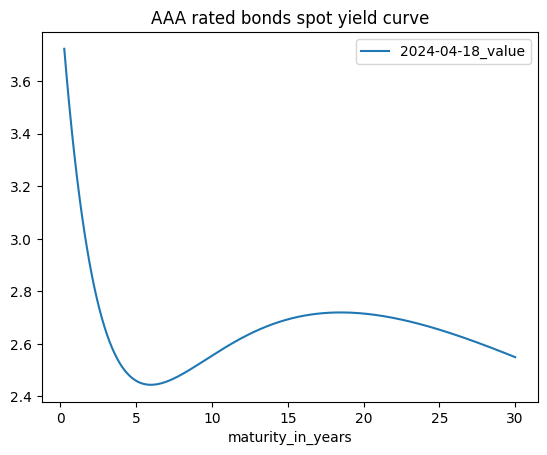

In [97]:
# exactly the same as on the Web:  https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
filtered_eurostat_euro_yield_df \
  .sort_values(by='maturity_in_months')[['maturity_in_years','2024-04-18_value']] \
  .plot.line(x='maturity_in_years',
            y='2024-04-18_value',
            title='AAA rated bonds spot yield curve')

# 4) [Code Snippet 5] Fundamental indicators

* Read about "Ratio Analysis" to learn about more ratios: https://www.investopedia.com/terms/r/ratioanalysis.asp
* https://algotrading101.com/learn/yahoo-finance-api-guide/

In [98]:
# let's select some set of stocks: e.g. top US companies on 'Employees':
# https://companiesmarketcap.com/usa/largest-american-companies-by-number-of-employees/

US_TOP_EMPLOYEES_STOCKS = ['WMT','AMZN','UPS','HD','CNXC','TGT','KR','UNH','BRK-B','SBUX']

# WMT
ticker = US_TOP_EMPLOYEES_STOCKS[0]

# WMT ticker
one_company = yf.Ticker(ticker)

In [99]:
# Fundamental info appears close earning dates, you need to download it and use quickly (before/after trading day),
#  unless you're a fundamental long-term investor looking for a several months-quarters-years strategy (period between buy and sell)
# This dfthis is the easiest thing to join with the main dataset and get "some" technical indicators present
eps_earnings = one_company.earnings_dates
eps_earnings['Ticker'] = ticker
eps_earnings

,EPS Estimate,Reported EPS,Surprise(%),Ticker
Earnings Date,,,,
2025-06-05 11:00:00-04:00,0.49,NaN,NaN,WMT
2025-02-20 08:00:00-05:00,NaN,NaN,NaN,WMT
2024-11-19 08:00:00-05:00,NaN,NaN,NaN,WMT
2024-08-15 08:00:00-04:00,NaN,NaN,NaN,WMT
2024-06-05 11:00:00-04:00,0.48,NaN,NaN,WMT
2024-05-16 08:00:00-04:00,0.48,NaN,NaN,WMT
2024-04-10 06:00:00-04:00,0.51,0.56,0.098,WMT
2024-04-03 06:00:00-04:00,0.51,0.56,0.098,WMT
2024-03-28 06:00:00-04:00,0.51,0.56,0.098,WMT


In [100]:
one_company.calendar

{'Dividend Date': datetime.date(2025, 1, 5),
 'Ex-Dividend Date': datetime.date(2024, 5, 8),
 'Earnings Date': [datetime.date(2024, 5, 16)],
 'Earnings High': 0.51,
 'Earnings Low': 0.47,
 'Earnings Average': 0.48,
 'Revenue High': 149213000000,
 'Revenue Low': 146276000000,
 'Revenue Average': 147903000000}

In [101]:
one_company.financials

,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Tax Effect Of Unusual Items,0.0,0.0,-612140000.0,0.0
Tax Rate For Calcs,0.255,0.336,0.254,0.333
Normalized EBITDA,36384000000.0,30089000000.0,33758000000.0,34031000000.0
Total Unusual Items,0.0,0.0,-2410000000.0,0.0
Total Unusual Items Excluding Goodwill,0.0,0.0,-2410000000.0,0.0
Net Income From Continuing Operation Net Minority Interest,15511000000.0,11680000000.0,13673000000.0,13510000000.0
Reconciled Depreciation,11853000000.0,10945000000.0,10658000000.0,11152000000.0
Reconciled Cost Of Revenue,490142000000.0,463721000000.0,429000000000.0,420315000000.0
EBITDA,36384000000.0,30089000000.0,31348000000.0,34031000000.0
EBIT,24531000000.0,19144000000.0,20690000000.0,22879000000.0


In [102]:
EPS = one_company.financials.loc['Basic EPS']
EPS

2024-01-31    1.92
2023-01-31    1.43
2022-01-31    1.63
2021-01-31    1.59
Name: Basic EPS, dtype: object

In [103]:
# or should we use NORMALIZED_EBITDA?
EBITDA = one_company.financials.loc['EBITDA']
EBITDA_margin = one_company.financials.loc['EBITDA'] /  one_company.financials.loc['Total Revenue']

In [104]:
EBITDA_margin

2024-01-31    0.056137
2023-01-31    0.049222
2022-01-31    0.054732
2021-01-31    0.060862
dtype: object

In [105]:
NET_INCOME = one_company.financials.loc['Net Income']
NET_INCOME_margin = one_company.financials.loc['Net Income'] /  one_company.financials.loc['Total Revenue']

In [106]:
NET_INCOME

2024-01-31    15511000000.0
2023-01-31    11680000000.0
2022-01-31    13673000000.0
2021-01-31    13510000000.0
Name: Net Income, dtype: object

In [107]:
# Compare with Public information - you can fully replicate the numbers (yearly and/or quarterly):
# https://www.wsj.com/market-data/quotes/WMT/financials/annual/income-statement
NET_INCOME_margin

2024-01-31    0.023932
2023-01-31    0.019107
2022-01-31    0.023872
2021-01-31    0.024162
dtype: object

In [108]:
# Combine the series into a DataFrame
df_fin_ratios = pd.DataFrame({
    'NET_INCOME_margin': 100.0 * NET_INCOME_margin, #for visualisation -- Margin in %
    'EBITDA_margin': 100.0 *EBITDA_margin, #for visualisation -- Margin in %
    'EPS': EPS
})

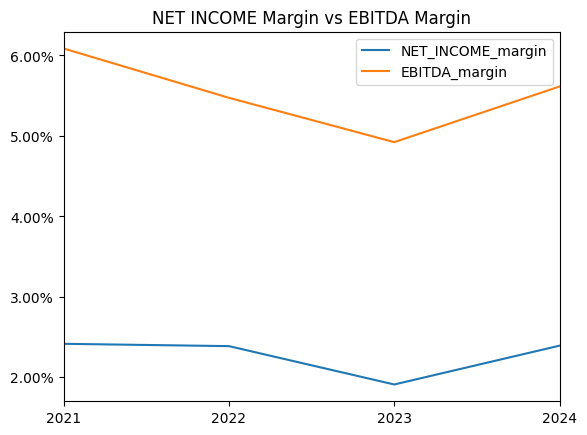

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming df_fin_ratios is your DataFrame containing the financial ratios
# Make sure you have already created this DataFrame

# Plotting the specified columns
ax = df_fin_ratios[['NET_INCOME_margin','EBITDA_margin']].plot.line()

# Setting the y-axis formatter to display values as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Adding title
plt.title('NET INCOME Margin vs EBITDA Margin')

# Displaying the plot
plt.show()

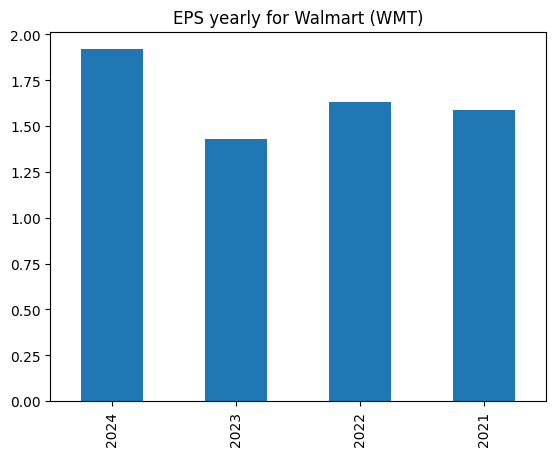

In [110]:
EPS_year = df_fin_ratios['EPS'].index.year

df_fin_ratios['EPS'].plot.bar(title = 'EPS yearly for Walmart (WMT)')

plt.xticks(range(len(EPS_year)), EPS_year)
# Displaying the plot
plt.show()

# 5) [Code snippet 7] Daily OHCLV data for a set of stocks

In [111]:
# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

In [112]:
ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS
ALL_TICKERS

['MSFT',
 'AAPL',
 'GOOG',
 'NVDA',
 'AMZN',
 'META',
 'BRK-B',
 'LLY',
 'AVGO',
 'V',
 'JPM',
 'NVO',
 'MC.PA',
 'ASML',
 'RMS.PA',
 'OR.PA',
 'SAP',
 'ACN',
 'TTE',
 'SIE.DE',
 'IDEXY',
 'CDI.PA',
 'RELIANCE.NS',
 'TCS.NS',
 'HDB',
 'BHARTIARTL.NS',
 'IBN',
 'SBIN.NS',
 'LICI.NS',
 'INFY',
 'ITC.NS',
 'HINDUNILVR.NS',
 'LT.NS']

In [113]:
import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  historyPrices = yf.download(tickers = ticker,
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Adj Close'] / historyPrices['Adj Close'].shift(i)
  historyPrices['growth_future_5d'] = historyPrices['Adj Close'].shift(-5) / historyPrices['Adj Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Adj Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Adj Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_5d_future'] = np.where(historyPrices['growth_future_5d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 MSFT


[*********************100%%**********************]  1 of 1 completed


1 AAPL


[*********************100%%**********************]  1 of 1 completed


2 GOOG


[*********************100%%**********************]  1 of 1 completed


3 NVDA


[*********************100%%**********************]  1 of 1 completed


4 AMZN


[*********************100%%**********************]  1 of 1 completed


5 META


[*********************100%%**********************]  1 of 1 completed


6 BRK-B


[*********************100%%**********************]  1 of 1 completed


7 LLY


[*********************100%%**********************]  1 of 1 completed


8 AVGO


[*********************100%%**********************]  1 of 1 completed


9 V


[*********************100%%**********************]  1 of 1 completed


10 JPM


[*********************100%%**********************]  1 of 1 completed


11 NVO


[*********************100%%**********************]  1 of 1 completed


12 MC.PA


[*********************100%%**********************]  1 of 1 completed


13 ASML


[*********************100%%**********************]  1 of 1 completed


14 RMS.PA


[*********************100%%**********************]  1 of 1 completed


15 OR.PA


[*********************100%%**********************]  1 of 1 completed


16 SAP


[*********************100%%**********************]  1 of 1 completed


17 ACN


[*********************100%%**********************]  1 of 1 completed


18 TTE


[*********************100%%**********************]  1 of 1 completed


19 SIE.DE


[*********************100%%**********************]  1 of 1 completed


20 IDEXY


[*********************100%%**********************]  1 of 1 completed


21 CDI.PA


[*********************100%%**********************]  1 of 1 completed


22 RELIANCE.NS


[*********************100%%**********************]  1 of 1 completed


23 TCS.NS


[*********************100%%**********************]  1 of 1 completed


24 HDB


[*********************100%%**********************]  1 of 1 completed


25 BHARTIARTL.NS


[*********************100%%**********************]  1 of 1 completed


26 IBN


[*********************100%%**********************]  1 of 1 completed


27 SBIN.NS


[*********************100%%**********************]  1 of 1 completed


28 LICI.NS


[*********************100%%**********************]  1 of 1 completed


29 INFY


[*********************100%%**********************]  1 of 1 completed


30 ITC.NS


[*********************100%%**********************]  1 of 1 completed


31 HINDUNILVR.NS


[*********************100%%**********************]  1 of 1 completed


32 LT.NS


[*********************100%%**********************]  1 of 1 completed


In [114]:
def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'


In [115]:
stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

In [116]:
# count of observations between US-EU-INDIA stocks
stocks_df.ticker_type.value_counts()

ticker_type
US       80717
EU       77058
INDIA    63334
Name: count, dtype: int64

In [117]:
# unique tickers
stocks_df.Ticker.nunique()

33

In [118]:
# count of observations by stock
stocks_df.Ticker.value_counts()

Ticker
LLY              13094
JPM              11128
AAPL             10940
NVO              10845
MSFT              9614
CDI.PA            8327
TTE               8192
ASML              7337
SAP               7208
HINDUNILVR.NS     7121
SBIN.NS           7119
RELIANCE.NS       7118
ITC.NS            7118
BRK-B             7045
SIE.DE            7045
AMZN              6788
NVDA              6363
INFY              6330
MC.PA             6257
RMS.PA            6257
OR.PA             6257
IBN               6065
ACN               5735
HDB               5734
LT.NS             5426
BHARTIARTL.NS     5423
TCS.NS            5394
GOOG              4962
V                 4061
AVGO              3712
IDEXY             3598
META              3010
LICI.NS            486
Name: count, dtype: int64

In [119]:
stocks_df.groupby(['Ticker','ticker_type']).Date.agg(['min','max'])

,,min,max
Ticker,ticker_type,,
AAPL,US,1980-12-12,2024-05-06
ACN,EU,2001-07-19,2024-05-06
AMZN,US,1997-05-15,2024-05-06
ASML,EU,1995-03-15,2024-05-06
AVGO,US,2009-08-06,2024-05-06
BHARTIARTL.NS,INDIA,2002-07-01,2024-05-06
BRK-B,US,1996-05-09,2024-05-06
CDI.PA,EU,1992-01-27,2024-05-06
GOOG,US,2004-08-19,2024-05-06


In [120]:
#  average growth 365days
stocks_df[stocks_df.Year>=2020].groupby(by=['Year','ticker_type']).growth_365d.mean()

Year  ticker_type
2020  EU             1.245388
      INDIA          1.101896
      US             1.484070
2021  EU             1.582170
      INDIA          1.546424
      US             1.797571
2022  EU             1.191169
      INDIA          1.379889
      US             1.182379
2023  EU             1.246533
      INDIA          1.201110
      US             1.203253
2024  EU             1.640018
      INDIA          1.302174
      US             2.160563
Name: growth_365d, dtype: float64

In [121]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [122]:
# filtering only on stats after 2000
stocks_df[stocks_df.Date>='2000-01-01'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182642 entries, 3490 to 221108
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Open                          182642 non-null  float64       
 1   High                          182642 non-null  float64       
 2   Low                           182642 non-null  float64       
 3   Close                         182642 non-null  float64       
 4   Adj Close                     182642 non-null  float64       
 5   Volume                        182642 non-null  int64         
 6   Ticker                        182642 non-null  object        
 7   Year                          182642 non-null  int32         
 8   Month                         182642 non-null  int32         
 9   Weekday                       182642 non-null  int32         
 10  Date                          182642 non-null  datetime64[ns]
 11  growth_1d      

In [123]:
stocks_df[stocks_df.Date=='2024-04-01'].tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_90d,growth_365d,growth_future_5d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_5d_future,ticker_type
195091,925.000000,984.450012,924.000000,970.599976,970.599976,4863536,LICI.NS,2024,4,0,...,1.599113,1.556710,1.026891,906.085004,953.950003,0,0.062281,1034.237352,1,INDIA
201418,17.889999,17.920000,17.500000,17.580000,17.580000,14601600,INFY,2024,4,0,...,1.003998,1.024508,1.015927,18.156000,18.777500,0,0.023891,13.940634,1,INDIA
208539,429.100006,431.350006,425.750000,426.700012,426.700012,9382308,ITC.NS,2024,4,0,...,0.987044,1.314436,1.005625,422.235004,416.537502,1,0.013124,130.246651,1,INDIA
215660,2270.000000,2295.000000,2262.000000,2285.899902,2285.899902,1427873,HINDUNILVR.NS,2024,4,0,...,0.917590,0.894050,0.992585,2266.539990,2327.240015,0,0.014436,1049.970071,0,INDIA
221086,3780.850098,3851.850098,3780.850098,3838.000000,3838.000000,1905190,LT.NS,2024,4,0,...,1.257886,2.010850,0.992144,3626.594971,3618.109985,1,0.018499,2188.619806,0,INDIA


#6) [Code Snippet 8] Technical Indicators with TA-lib
* PythonInvest article on Tech. Indicators
* Code for generating 100+ tech. indicators/patterns : https://github.com/realmistic/PythonInvest-basic-fin-analysis/blob/master/colab_notebooks/Part14_Exploring_Tech_Indicators_For_Stocks_and_Crypto.ipynb

Indicator groups: https://github.com/TA-Lib/ta-lib-python/blob/master/README.md

* Overlap Studies (17)
* Momentum Indicators (30+)
* Volume Indicators (3)
* Cycle Indicators (5)
* Price Transform (4)
* Volatility Indicators (3)
* Pattern Recognition (60)

In [124]:
# https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
# Update (apr 2023): Colab is now Python 3.10
# there are some other (older) ways to install talib

#url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
#!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
#url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
#!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

## 6.1) Momentum indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/momentum_indicators.md

In [125]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index <dateTime, ticker>
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

## 6.2 Volume, Volatility, Cycle, Price indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md

In [126]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

## 6.3) Pattern indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md

In [127]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

## 6.4) Calculate Tech Indicators and Merge to the original dataframe

In [128]:
# Volume needs to be float, not int
stocks_df['Volume'] = stocks_df['Volume']*1.0

In [129]:
# to resolve an error "Exception: input array type is not double"
# https://stackoverflow.com/questions/51712269/how-to-run-ta-lib-on-multiple-columns-of-a-pandas-dataframe
for f in ['Open','High','Low','Close', 'Volume', 'Adj Close']:
  stocks_df.loc[:,f] = stocks_df.loc[:,f].astype('float64')

In [130]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221109 entries, 0 to 221108
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Open                          221109 non-null  float64       
 1   High                          221109 non-null  float64       
 2   Low                           221109 non-null  float64       
 3   Close                         221109 non-null  float64       
 4   Adj Close                     221109 non-null  float64       
 5   Volume                        221109 non-null  float64       
 6   Ticker                        221109 non-null  object        
 7   Year                          221109 non-null  int32         
 8   Month                         221109 non-null  int32         
 9   Weekday                       221109 non-null  int32         
 10  Date                          221109 non-null  datetime64[ns]
 11  growth_1d    

In [131]:
import pandas as pd
# supress warnings
pd.options.mode.chained_assignment = None  # default='warn'

# adding Momentum / Pattern/ Volume features to all tickers - one by one
merged_df_with_tech_ind = pd.DataFrame({'A' : []})

current_ticker_data = None
i=0
for ticker in ALL_TICKERS:
  i+=1
  print(f'{i}/{len(ALL_TICKERS)} Current ticker is {ticker}')
  current_ticker_data = stocks_df[stocks_df.Ticker.isin([ticker])]
  # need to have same 'utc' time on both sides
  # https://stackoverflow.com/questions/73964894/you-are-trying-to-merge-on-datetime64ns-utc-and-datetime64ns-columns-if-yo
  current_ticker_data['Date']= pd.to_datetime(current_ticker_data['Date'], utc=True)

  # 3 calls to get additional features
  df_current_ticker_momentum_indicators = talib_get_momentum_indicators_for_one_ticker(current_ticker_data)
  df_current_ticker_momentum_indicators["Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)
  # df_current_ticker_momentum_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)

  df_current_ticker_volume_indicators = talib_get_volume_volatility_cycle_price_indicators(current_ticker_data)
  df_current_ticker_volume_indicators["Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)
  # df_current_ticker_volume_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)

  df_current_ticker_pattern_indicators = talib_get_pattern_recognition_indicators(current_ticker_data)
  df_current_ticker_pattern_indicators["Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)
  # df_current_ticker_pattern_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)

  # merge to one df
  m1 = pd.merge(current_ticker_data, df_current_ticker_momentum_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m2 = pd.merge(m1, df_current_ticker_volume_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m3 = pd.merge(m2, df_current_ticker_pattern_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")

  if merged_df_with_tech_ind.empty:
    merged_df_with_tech_ind = m3
  else:
    merged_df_with_tech_ind = pd.concat([merged_df_with_tech_ind,m3], ignore_index = False)

1/33 Current ticker is MSFT
2/33 Current ticker is AAPL
3/33 Current ticker is GOOG
4/33 Current ticker is NVDA
5/33 Current ticker is AMZN
6/33 Current ticker is META
7/33 Current ticker is BRK-B
8/33 Current ticker is LLY
9/33 Current ticker is AVGO
10/33 Current ticker is V
11/33 Current ticker is JPM
12/33 Current ticker is NVO
13/33 Current ticker is MC.PA
14/33 Current ticker is ASML
15/33 Current ticker is RMS.PA
16/33 Current ticker is OR.PA
17/33 Current ticker is SAP
18/33 Current ticker is ACN
19/33 Current ticker is TTE
20/33 Current ticker is SIE.DE
21/33 Current ticker is IDEXY
22/33 Current ticker is CDI.PA
23/33 Current ticker is RELIANCE.NS
24/33 Current ticker is TCS.NS
25/33 Current ticker is HDB
26/33 Current ticker is BHARTIARTL.NS
27/33 Current ticker is IBN
28/33 Current ticker is SBIN.NS
29/33 Current ticker is LICI.NS
30/33 Current ticker is INFY
31/33 Current ticker is ITC.NS
32/33 Current ticker is HINDUNILVR.NS
33/33 Current ticker is LT.NS


In [132]:
merged_df_with_tech_ind[merged_df_with_tech_ind.Date=='2024-04-01'].tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
463,925.000000,984.450012,924.000000,970.599976,970.599976,4863536.0,LICI.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
6304,17.889999,17.920000,17.500000,17.580000,17.580000,14601600.0,INFY,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
7095,429.100006,431.350006,425.750000,426.700012,426.700012,9382308.0,ITC.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
7098,2270.000000,2295.000000,2262.000000,2285.899902,2285.899902,1427873.0,HINDUNILVR.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
5403,3780.850098,3851.850098,3780.850098,3838.000000,3838.000000,1905190.0,LT.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
merged_df_with_tech_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221109 entries, 0 to 5425
Columns: 144 entries, Open to cdlxsidegap3methods
dtypes: datetime64[ns, UTC](1), float64(71), int32(67), int64(3), object(2)
memory usage: 188.1+ MB


# 7) [Code snippet 9] Merge All Together

In [134]:
merged_df_with_tech_ind.head(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
0,0.088542,0.101563,0.088542,0.097222,0.060163,1.031789e+09,MSFT,1986,3,3,...,0,0,0,0,0,0,0,0,0,0


In [135]:
merged_df_with_tech_ind.shape

(221109, 144)

In [136]:
# make sure it is dateTime with no timezone
merged_df_with_tech_ind['Date'] = pd.to_datetime(merged_df_with_tech_ind['Date']).dt.tz_localize(None)

In [137]:
# merge with dax_daily_to_merge
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2024-05-06,1.009644,1.013553,1.004783,1.008886,1.087933,1.263628


In [138]:
m2 = pd.merge(merged_df_with_tech_ind,
              dax_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [139]:
m2.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,5,0,...,0,0,0,0,1.009644,1.013553,1.004783,1.008886,1.087933,1.263628


In [140]:
# check the same number of records, but columns increased
m2.shape

(221109, 150)

In [141]:
# merge with dax_daily_to_merge
snp500_to_merge.tail(1)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2024-05-06,1.010326,1.032351,1.02621,0.98979,1.085029,1.306506


In [142]:
m3 = pd.merge(m2,
              snp500_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [143]:
m3.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,5,0,...,1.004783,1.008886,1.087933,1.263628,1.010326,1.032351,1.02621,0.98979,1.085029,1.306506


In [144]:
m3.shape

(221109, 156)

In [145]:
m4 = pd.merge(m3,
              dji_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [146]:
m4.shape

(221109, 162)

In [147]:
m4.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,5,0,...,1.02621,0.98979,1.085029,1.306506,1.004566,1.025037,1.020125,0.984202,1.03481,1.151325


In [148]:
m5 = pd.merge(m4,
              epi_etf_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [149]:
m5.shape

(221109, 168)

In [150]:
# define quarter as the first date of qtr
m5['Quarter'] = m5['Date'].dt.to_period('Q').dt.to_timestamp()
m5['Quarter']

0      1986-01-01
1      1986-01-01
2      1986-01-01
3      1986-01-01
4      1986-01-01
          ...    
5421   2024-04-01
5422   2024-04-01
5423   2024-04-01
5424   2024-04-01
5425   2024-04-01
Name: Quarter, Length: 221109, dtype: datetime64[ns]

In [151]:
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2024-04-01,0.022151,0.005343


In [152]:
m6 = pd.merge(m5,
              gdppot_to_merge,
              how='left',
              left_on='Quarter',
              right_index=True,
              validate = "many_to_one"
              )

In [153]:
m6.tail(2)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_dji_365d,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq
5424,3610.000000,3622.0,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,5,4,...,1.152904,0.996937,1.008857,1.019239,1.066230,1.122997,1.390207,2024-04-01,0.022151,0.005343
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,5,0,...,1.151325,0.988147,0.995137,0.999112,1.055321,1.105871,1.374986,2024-04-01,0.022151,0.005343


In [154]:
m6.shape

(221109, 171)

In [155]:
m6['Month'] = m6['Date'].dt.to_period('M').dt.to_timestamp()
m6['Month']

0      1986-03-01
1      1986-03-01
2      1986-03-01
3      1986-03-01
4      1986-03-01
          ...    
5421   2024-04-01
5422   2024-04-01
5423   2024-05-01
5424   2024-05-01
5425   2024-05-01
Name: Month, Length: 221109, dtype: datetime64[ns]

In [156]:
cpilfesl_to_merge.tail(1)

,cpi_core_yoy,cpi_core_mom
DATE,,
2024-03-01,0.037973,0.00359


In [157]:
m7 = pd.merge(m6,
              cpilfesl_to_merge,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [158]:
# PROBLEM! Last month is not defined
m7.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,0.995137,0.999112,1.055321,1.105871,1.374986,2024-04-01,0.022151,0.005343,NaN,NaN


In [159]:
fields_to_fill = ['cpi_core_yoy',	'cpi_core_mom']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m7[field] = m7[field].fillna(method='ffill')


C:\Users\rcata\AppData\Local\Temp\ipykernel_21008\460936599.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [160]:
m7.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,0.995137,0.999112,1.055321,1.105871,1.374986,2024-04-01,0.022151,0.005343,0.037973,0.00359


In [161]:
fedfunds.tail(1)

,FEDFUNDS
DATE,
2024-04-01,5.33


In [162]:
m8 = pd.merge(m7,
              fedfunds,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [163]:
m8.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,0.999112,1.055321,1.105871,1.374986,2024-04-01,0.022151,0.005343,0.037973,0.00359,NaN


In [164]:
fields_to_fill = ['FEDFUNDS']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m8[field] = m8[field].fillna(method='ffill')


C:\Users\rcata\AppData\Local\Temp\ipykernel_21008\2787103881.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [165]:
m8.tail(1)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,0.999112,1.055321,1.105871,1.374986,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33


In [166]:
dgs1.tail(1)

,DGS1
DATE,
2024-05-03,5.12


In [167]:
m9 = pd.merge(m8,
              dgs1,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [168]:
# fix last day later
m9.tail(2)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1
5424,3610.000000,3622.0,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,2024-05-01,4,...,1.066230,1.122997,1.390207,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,5.12
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,1.055321,1.105871,1.374986,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN


In [169]:
m10 = pd.merge(m9,
              dgs5,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [170]:
# fix last day later
m10.tail(2)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5
5424,3610.000000,3622.0,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,2024-05-01,4,...,1.122997,1.390207,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,5.12,4.48
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,1.105871,1.374986,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN,NaN


In [171]:
m11 = pd.merge(m10,
              dgs10,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [172]:
m11.tail(2)

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10
5424,3610.000000,3622.0,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,2024-05-01,4,...,1.390207,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,5.12,4.48,4.5
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,1.374986,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN,NaN,NaN


In [173]:
vix_to_merge

Date
1990-01-02    17.240000
1990-01-03    18.190001
1990-01-04    19.219999
1990-01-05    20.110001
1990-01-08    20.260000
                ...    
2024-04-30    15.650000
2024-05-01    15.390000
2024-05-02    14.680000
2024-05-03    13.490000
2024-05-06    13.490000
Name: Adj Close, Length: 8652, dtype: float64

In [174]:
m12 = pd.merge(m11,
              vix_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [175]:
m12.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10,Adj Close_y
5424,3610.000000,3622.0,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,2024-05-01,4,...,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,5.12,4.48,4.5,13.49
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,2024-04-01,0.022151,0.005343,0.037973,0.00359,5.33,NaN,NaN,NaN,13.49


In [176]:
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2024-05-03,0.999913,1.003317,0.989030,1.053427,1.117593,1.312289
2024-05-06,1.014398,1.014001,1.000987,1.080626,1.133078,1.342293


In [177]:
m13 = pd.merge(m12,
              gold_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [178]:
m13.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,DGS1,DGS5,DGS10,Adj Close_y,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
5424,3610.000000,3622.0,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,2024-05-01,4,...,5.12,4.48,4.5,13.49,0.999913,1.003317,0.989030,1.053427,1.117593,1.312289
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,NaN,NaN,NaN,13.49,1.014398,1.014001,1.000987,1.080626,1.133078,1.342293


In [179]:
m14 = pd.merge(m13,
              crude_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [180]:
m14.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
5424,3610.000000,3622.0,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,2024-05-01,4,...,0.989030,1.053427,1.117593,1.312289,0.989360,0.953375,0.943244,0.963488,1.061854,0.975400
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,1.000987,1.080626,1.133078,1.342293,1.006913,0.995570,0.941127,0.975443,1.040757,0.986454


In [181]:
m15 = pd.merge(m14,
              brent_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [182]:
m15.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
5424,3610.000000,3622.0,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,2024-05-01,4,...,0.943244,0.963488,1.061854,0.975400,0.991514,0.944229,0.942513,0.967125,1.049197,0.946816
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,0.941127,0.975443,1.040757,0.986454,1.006268,1.000479,0.937872,0.977174,1.029727,0.954603


In [183]:
m16 = pd.merge(m15,
              btc_usd_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [184]:
m16.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5424,3610.000000,3622.0,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,2024-05-01,4,...,0.942513,0.967125,1.049197,0.946816,1.063704,1.037155,0.986425,0.953153,1.462818,2.180063
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,0.937872,0.977174,1.029727,0.954603,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
fields_to_fill = ['gdppot_us_yoy','gdppot_us_qoq','cpi_core_yoy','cpi_core_mom','FEDFUNDS','DGS1','DGS5','DGS10']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m16[field] = m16[field].fillna(method='ffill')

C:\Users\rcata\AppData\Local\Temp\ipykernel_21008\2136591724.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [186]:
m16.tail(2)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5424,3610.000000,3622.0,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,2024-05-01,4,...,0.942513,0.967125,1.049197,0.946816,1.063704,1.037155,0.986425,0.953153,1.462818,2.180063
5425,3522.800049,3527.0,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,0.937872,0.977174,1.029727,0.954603,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
m16.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221109 entries, 0 to 5425
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(66), int64(3), object(2)
memory usage: 286.8+ MB


In [188]:
date = m16.Date.max()
date_str = date.strftime('%Y_%m_%d')
print(date_str)

2024_05_06


In [189]:
m16.to_parquet(f'stocks_df_combined_{date_str}.parquet.brotli',
              compression='brotli')

In [190]:
m16.head()

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
0,0.088542,0.101563,0.088542,0.097222,0.060163,1.031789e+09,MSFT,1986,1986-03-01,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.097222,0.102431,0.097222,0.100694,0.062311,3.081600e+08,MSFT,1986,1986-03-01,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.100694,0.103299,0.100694,0.102431,0.063386,1.331712e+08,MSFT,1986,1986-03-01,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.102431,0.103299,0.098958,0.099826,0.061774,6.776640e+07,MSFT,1986,1986-03-01,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.099826,0.100694,0.097222,0.098090,0.060700,4.789440e+07,MSFT,1986,1986-03-01,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
